In [6]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.optimize import minimize
from scipy.sparse import csr_array
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

# default parameters of the plot layout
plt.rcParams["text.usetex"] = True  # use latex
plt.rcParams["font.size"] = 13
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True

def get_Np(Nx, Ny):
    """Returns the number of plaquettes in terms of the number of data qubits
       at each direction in the lattice (code distance)"""
    return (Nx - 1)*(Ny - 1)

def get_Nl(Nx, Ny):
    """Returns the number of links in terms of the number of data qubits
       at each direction in the rotated lattice (code distance)"""
    return (Nx - 1)*Ny + Nx*(Ny - 1)

def get_dim(Nx, Ny):
    """Returns the dimension of the Hilbert space in terms of the
       number of data qubits in the rotated lattice (code distance)"""
    power = get_Np(Nx, Ny) + 1
    return 2**power

def link_array_from_plaquette_product(ppindex, Nx, Ny):
    p_state = np.array(list(f"{ppindex:0{get_Np(Nx, Ny)}b}")[::-1], dtype=int)
    links = np.zeros(get_Nl(Nx, Ny), dtype=int)
    present_plaquettes = np.where(p_state == 1)[0]
    pindices_0 = ((present_plaquettes // (Nx - 1))*(2*Nx - 1) + (present_plaquettes % (Nx - 1))).astype(int)
    pindices_1 = (pindices_0 + (Nx - 1)).astype(int)
    pindices_2 = (pindices_1 + 1).astype(int)
    pindices_3 = (pindices_2 + (Nx - 1)).astype(int)
    np.add.at(links, pindices_0, 1)
    np.add.at(links, pindices_1, 1)
    np.add.at(links, pindices_2, 1)
    np.add.at(links, pindices_3, 1)
    links = links % 2
    return links

def red_sigma_x_sum_diag(Nx, Ny):
    """Returns the diagonal matrix corresponding to the sum of 
       sigma_x in the considered basis in a basis restricted to one
       of the two logical blocks"""
    negated_link_sum = np.array([link_array_from_plaquette_product(i, Nx, Ny).sum() for i in range(2**get_Np(Nx, Ny))])
    diag = get_Nl(Nx, Ny) - 2*negated_link_sum
    return diag

def red_pn_sum_ones_positions(Nx, Ny):
    Np = get_Np(Nx, Ny)
    n_arr = np.ones((2**Np, Np), dtype=int)*np.arange(1, Np + 1)
    rows = (np.ones((Np, 2**Np), dtype=int)*np.arange(2**Np)).T
    reference_indices = 2**(Np - (n_arr - 1))*(rows // 2**(Np - (n_arr-1)))
    ones_positions = reference_indices + (rows + 2**(Np - n_arr)) % 2**(Np - (n_arr - 1))
    return ones_positions

def tanhbeta_powers(Np):
    return np.array([list(f"{i:0{Np}b}") for i in range(2**Np)], dtype=int).sum(axis=1)

def red_H_sparse(lamb, Nx, Ny, red_sigma_x_sum_diag_cache=None, red_pn_sum_ones_pos_cache=None):
    if red_sigma_x_sum_diag_cache is None:
        red_sigma_x_sum_diag_cache = red_sigma_x_sum_diag(Nx, Ny)
    if red_pn_sum_ones_pos_cache is None:
        red_pn_sum_ones_pos_cache = red_pn_sum_ones_positions(Nx, Ny)

    Np = get_Np(Nx, Ny)
    ham_el_col_pos = np.hstack((red_pn_sum_ones_pos_cache, np.arange(2**Np).reshape((2**Np, 1))))
    ham_el_row_pos = (np.ones((Np + 1, 2**Np), dtype=int)*np.arange(2**Np)).T
    ham_el_values = np.hstack((-1/lamb*np.ones((2**Np, Np)), -lamb*red_sigma_x_sum_diag_cache.reshape(2**Np, 1)))
    return csr_array((ham_el_values.flatten(), (ham_el_row_pos.flatten(), ham_el_col_pos.flatten())), shape=(2**Np, 2**Np))

def red_ngs(lamb, Nx, Ny, red_sigma_x_sum_diag_cache=None, red_pn_sum_ones_pos_cache=None):
    if red_sigma_x_sum_diag_cache is None:
        red_sigma_x_sum_diag_cache = red_sigma_x_sum_diag(Nx, Ny)
    if red_pn_sum_ones_pos_cache is None:
        red_pn_sum_ones_pos_cache = red_pn_sum_ones_positions(Nx, Ny)

    H_s = red_H_sparse(lamb, Nx, Ny, red_sigma_x_sum_diag_cache, red_pn_sum_ones_pos_cache)
    E_gs, gs = eigsh(H_s, k=1, which="SA")
    return gs[:, 0]

def red_E_ngs(lamb, Nx, Ny, red_sigma_x_sum_diag_cache=None, red_pn_sum_ones_pos_cache=None):
    if red_sigma_x_sum_diag_cache is None:
        red_sigma_x_sum_diag_cache = red_sigma_x_sum_diag(Nx, Ny)
    if red_pn_sum_ones_pos_cache is None:
        red_pn_sum_ones_pos_cache = red_pn_sum_ones_positions(Nx, Ny)
    
    H_s = red_H_sparse(lamb, Nx, Ny, red_sigma_x_sum_diag_cache, red_pn_sum_ones_pos_cache)
    E_gs, gs = eigsh(H_s, k=1, which="SA")
    return E_gs[0]

def product_indices_containing_plaquette(pindex, Nx, Ny):
    Np = get_Np(Nx, Ny)
    non_fixed_pproduct_strings = np.array([list(f"{i:0{(Np-1)}b}")[::-1] for i in range(2**(Np - 1))], dtype=int)
    ones_to_insert = np.ones(2**(Np - 1))
    pproduct_strings = np.insert(non_fixed_pproduct_strings, pindex, ones_to_insert, axis=1)
    pproduct_indices = np.sum(pproduct_strings * 2**np.arange(Np), axis=1)
    return pproduct_indices

def magnetization(lamb, Nx, Ny, red_sigma_x_sum_diag_cache=None, red_pn_sum_ones_pos_cache=None, neg_pind=None):
    if red_sigma_x_sum_diag_cache is None:
        red_sigma_x_sum_diag_cache = red_sigma_x_sum_diag(Nx, Ny)
    if red_pn_sum_ones_pos_cache is None:
        red_pn_sum_ones_pos_cache = red_pn_sum_ones_positions(Nx, Ny)
    
    pind = range(get_Np(Nx, Ny)) if neg_pind is None else neg_pind
    ngs = red_ngs(lamb, Nx, Ny)
    single_site_mags = np.zeros(len(pind))
    mag_arr = np.zeros(len(pind))
    for j, neg_p_index in enumerate(pind):
        plaquettes_to_negate = product_indices_containing_plaquette(neg_p_index, Nx, Ny)
        thooft_times_ngs = ngs.copy()
        thooft_times_ngs[plaquettes_to_negate] = -thooft_times_ngs[plaquettes_to_negate]
        single_site_mags[j] = np.conj(ngs).dot(thooft_times_ngs)
    return single_site_mags # single_site_mags.mean()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from scipy.sparse.linalg import eigs
H = red_H_sparse(lamb=1, Nx=4, Ny=4)
e, v = eigs(H,k=1)
print(e)

[-25.12283892+0.j]


diagonalizing exact H for h:0.1
diagonalizing exact H for h:0.1473684210526316
diagonalizing exact H for h:0.19473684210526315
diagonalizing exact H for h:0.24210526315789474
diagonalizing exact H for h:0.2894736842105263
diagonalizing exact H for h:0.33684210526315794
diagonalizing exact H for h:0.38421052631578945
diagonalizing exact H for h:0.43157894736842106
diagonalizing exact H for h:0.4789473684210527
diagonalizing exact H for h:0.5263157894736842
diagonalizing exact H for h:0.5736842105263158
diagonalizing exact H for h:0.6210526315789474
diagonalizing exact H for h:0.6684210526315789
diagonalizing exact H for h:0.7157894736842105
diagonalizing exact H for h:0.7631578947368421
diagonalizing exact H for h:0.8105263157894737
diagonalizing exact H for h:0.8578947368421053
diagonalizing exact H for h:0.9052631578947369
diagonalizing exact H for h:0.9526315789473684
diagonalizing exact H for h:1.0


/Users/fradm98/opt/anaconda3/envs/mps/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<function matplotlib.pyplot.show(close=None, block=None)>

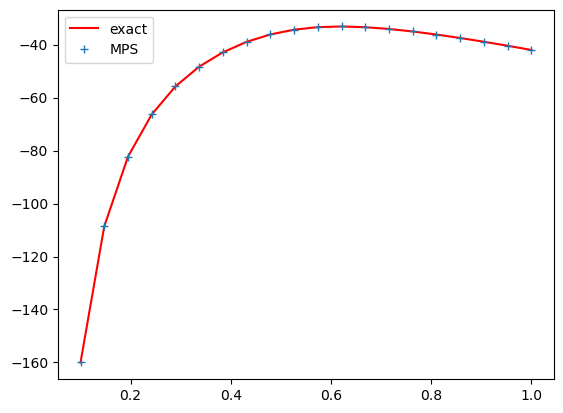

In [7]:
import matplotlib.pyplot as plt
path = "/Users/fradm98/Google Drive/My Drive/projects/1_Z2"
h_i = 0.1
h_f = 1.0
npoints = 20
interval = np.linspace(h_i,h_f,npoints)
E_mps = np.load(f"{path}/results/energy_data/energies_Z2_dual_direct_lattice_4x4_vacuum_sector_bc_obc_None-None_h_0.1-1.0_delta_20_chi_64.npy")

E = []
for h in interval:
    print(f"diagonalizing exact H for h:{h}")
    H = red_H_sparse(lamb=h, Nx=5, Ny=5)
    e, v = eigs(H,k=1)
    E.append(e)

plt.plot(interval, E, color='r', label="exact")
plt.plot(interval, E_mps[:,-1], '+', label="MPS")
plt.legend()
plt.show

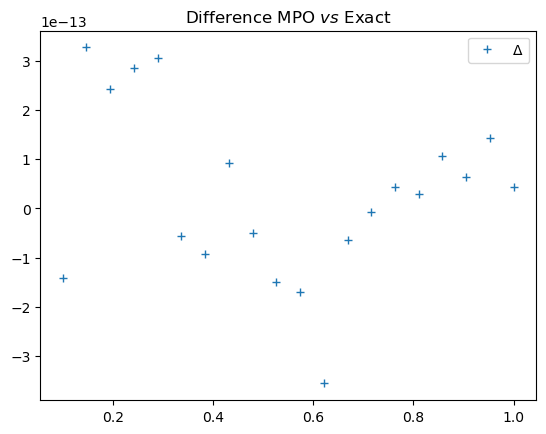

In [9]:
E = np.array([e.real for e in E]).reshape(len(E))
plt.title("Difference MPO $vs$ Exact")
plt.plot(interval, E-E_mps[:,-1], '+', label="$\\Delta$")
plt.legend()

<function matplotlib.pyplot.show(close=None, block=None)>

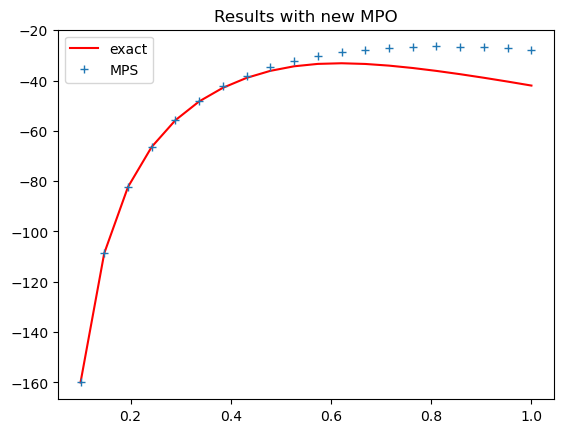

In [4]:
plt.title("Results with new MPO")
plt.plot(interval, E, color='r', label="exact")
plt.plot(interval, E_mps[:,-1], '+', label="MPS")
plt.legend()
plt.show

/Users/fradm98/opt/anaconda3/envs/mps/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<function matplotlib.pyplot.show(close=None, block=None)>

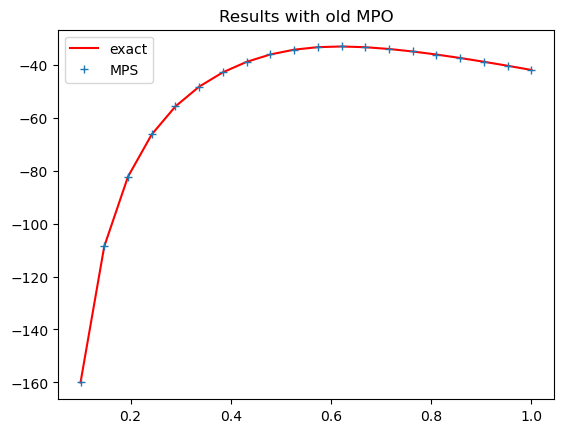

In [5]:
plt.title("Results with old MPO")
plt.plot(interval, E, color='r', label="exact")
plt.plot(interval, E_mps[:,-1], '+', label="MPS")
plt.legend()
plt.show

In [12]:
E = [e.real for e in E]
np.savetxt(f"{path}/results/exact/energy_data/energies_Z2_dual_direct_lattice_4x4_vacuum_sector_None-None_h_2.0-6.0_delta_20", E)

In [15]:
plaq = magnetization(lamb=h, Nx=5, Ny=5)

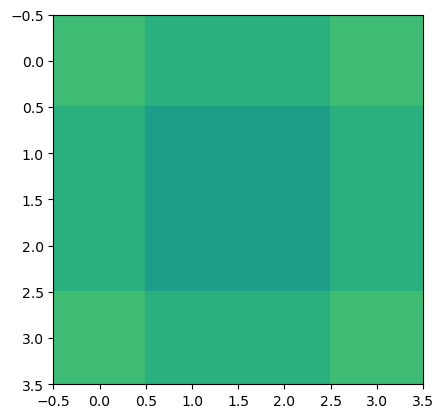

In [19]:
plaqs = np.array_split(plaq, 4)
plt.imshow(plaqs, vmin=-1, vmax=1)

In [20]:
P = []
for h in interval:
    p = magnetization(lamb=h, Nx=5, Ny=5)
    p = np.array_split(p, 4)
    P.append(p)

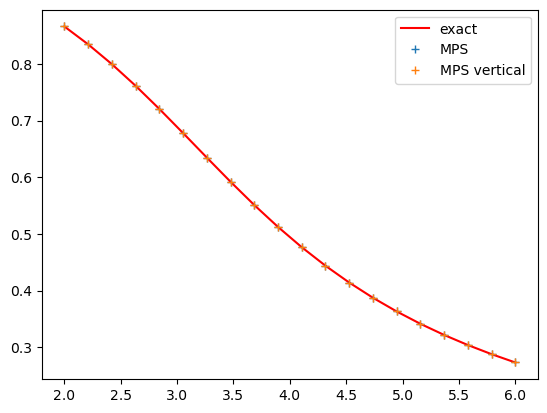

In [29]:
string = [p[:][1][-1] for p in P]
string_mps = np.load(f"{path}/results/thooft/thooft_string_first_moment_3-1_horizontal_Z2_dual_direct_lattice_4x4_vacuum_sector_None-None_h_2.0-6.0_delta_20_chi_64.npy")
string_mps_v = np.load(f"{path}/results/thooft/thooft_string_first_moment_3-1_vertical_Z2_dual_direct_lattice_4x4_vacuum_sector_None-None_h_2.0-6.0_delta_20_chi_64.npy")
plt.plot(interval, string, color='r', label="exact")
plt.plot(interval, string_mps, '+', label="MPS")
plt.plot(interval, string_mps_v, '+', label="MPS vertical")
plt.legend()
plt.show()

In [31]:
np.save(f"{path}/results/exact/thooft/thooft_string_first_moment_3-1_vertical_Z2_dual_direct_lattice_4x4_vacuum_sector_None-None_h_2.0-6.0_delta_20.npy", string)

## vertical charge MPO vs horizontal charge MPO

In [3]:
from qs_mps.mpo_class import MPO_ladder
from qs_mps.utils import tensor_shapes, mpo_to_matrix

l = 3
L = 3
model = "Z2_dual"
lamb = 0.8
cx = [0,3]
cy = [1,1]

mpo_vc = MPO_ladder(l,L,model,lamb)
mpo_vc.add_charges(cx,cy)
mpo_vc.mpo_Z2_ladder_generalized_obc_old()
print(mpo_vc.charges)
tensor_shapes(mpo_vc.mpo)
# display(mpo_vc.mpo[0][0], mpo_vc.mpo[0][:,-1])

mpo_hc = MPO_ladder(l,L,model,lamb)
mpo_hc.add_charges(cx,cy)
mpo_hc.mpo_Z2_ladder_generalized_obc()
print(mpo_hc.charges)
tensor_shapes(mpo_hc.mpo)
# display(mpo_hc.mpo[0][0], mpo_hc.mpo[0][:,-1])
charges = mpo_vc.charges.copy()

[[ 1.  1.  1.  1.]
 [-1.  1.  1. -1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]]
(5, 5, 8, 8)
(5, 5, 8, 8)
(5, 5, 8, 8)
[[ 1.  1.  1.  1.]
 [-1.  1.  1. -1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]]
(5, 5, 8, 8)
(5, 5, 8, 8)
(5, 5, 8, 8)


In [4]:
from qs_mps.sparse_hamiltonians_and_operators import sparse_pauli_x, sparse_pauli_z, identity
import numpy as np
X0 = sparse_pauli_x(n=0, L=l).toarray()
X1 = sparse_pauli_x(n=1, L=l).toarray()
X2 = sparse_pauli_x(n=2, L=l).toarray()
Z0 = sparse_pauli_z(n=0, L=l).toarray()
Z1 = sparse_pauli_z(n=1, L=l).toarray()
Z2 = sparse_pauli_z(n=2, L=l).toarray()

H_loc_0 = - lamb*(np.prod(charges[0,:1])*Z0+np.prod(charges[l,:1])*Z2 + np.prod(charges[1,:1])*(Z0@Z1) + np.prod(charges[2,:1])*(Z1@Z2) + (Z0+Z1+Z2)) - 1/lamb*(X0+X1+X2)
H_loc_1 = - lamb*(np.prod(charges[0,:2])*Z0+np.prod(charges[l,:2])*Z2 + np.prod(charges[1,:2])*(Z0@Z1) + np.prod(charges[2,:2])*(Z1@Z2)) - 1/lamb*(X0+X1+X2)
H_loc_2 = - lamb*(np.prod(charges[0,:3])*Z0+np.prod(charges[l,:3])*Z2 + np.prod(charges[1,:3])*(Z0@Z1) + np.prod(charges[2,:3])*(Z1@Z2) + (np.prod(charges[:1,:4])*Z0+np.prod(charges[:2,:4])*Z1+np.prod(charges[:3,:4])*Z2)) - 1/lamb*(X0+X1+X2)

In [9]:
from qs_mps.checks import check_matrix
from scipy.sparse import csr_matrix
H_loc_0 = csr_matrix(H_loc_0)
H_loc_1 = csr_matrix(H_loc_1)
H_loc_2 = csr_matrix(H_loc_2)

H_loc_0_hc = csr_matrix(mpo_hc.mpo[0][0,-1])
H_loc_1_hc = csr_matrix(mpo_hc.mpo[1][0,-1])
H_loc_2_hc = csr_matrix(mpo_hc.mpo[2][0,-1])
display(check_matrix(H_loc_0, H_loc_0_hc))
display(check_matrix(H_loc_1, H_loc_1_hc))
display(check_matrix(H_loc_2, H_loc_2_hc))

H_loc_0_vc = csr_matrix(mpo_vc.mpo[0][0,-1])
display(check_matrix(H_loc_0, H_loc_0_vc))


1.1462055724207507e-17

2.0619879459134108e-17

1.1462055724207507e-17

    ERROR: A and B are DIFFERENT MATRICES


ValueError:     NORM 10.119288512538814, RATIO 0.6125818500525289

In [30]:
I = identity(n=2**l).toarray()
O = csr_matrix((2**l, 2**l), dtype=complex).toarray()
mpo_0 = np.array([[I, Z0, Z1, Z2, H_loc_0],
         [O,O,O,O,-lamb*Z0],
         [O,O,O,O,-lamb*Z1],
         [O,O,O,O,-lamb*Z2],
         [O,O,O,O,I]])
mpo_1 = np.array([[I, Z0, Z1, Z2, H_loc_1],
         [O,O,O,O,-lamb*Z0],
         [O,O,O,O,-lamb*Z1],
         [O,O,O,O,-lamb*Z2],
         [O,O,O,O,I]])
mpo_2 = np.array([[I, Z0, Z1, Z2, H_loc_2],
         [O,O,O,O,-lamb*Z0],
         [O,O,O,O,-lamb*Z1],
         [O,O,O,O,-lamb*Z2],
         [O,O,O,O,I]])
mpo_built = [mpo_0,mpo_1,mpo_2]

In [33]:
H_hc = csr_matrix(mpo_to_matrix(mpo_hc.mpo))
H_vc = csr_matrix(mpo_to_matrix(mpo_vc.mpo))
H_built = csr_matrix(mpo_to_matrix(mpo_built))
# check_matrix(H_hc, H_vc)
check_matrix(H_hc, H_built)
# check_matrix(H_vc, H_built)

1.4627414017393682e-17

In [15]:
H_hc.toarray(), H_vc.toarray()

(array([[-14.4 +0.j,  -1.25+0.j,  -1.25+0.j, ...,   0.  +0.j,   0.  +0.j,
           0.  +0.j],
        [ -1.25+0.j,  -8.  +0.j,   0.  +0.j, ...,   0.  +0.j,   0.  +0.j,
           0.  +0.j],
        [ -1.25+0.j,   0.  +0.j, -11.2 +0.j, ...,   0.  +0.j,   0.  +0.j,
           0.  +0.j],
        ...,
        [  0.  +0.j,   0.  +0.j,   0.  +0.j, ...,   4.8 +0.j,   0.  +0.j,
          -1.25+0.j],
        [  0.  +0.j,   0.  +0.j,   0.  +0.j, ...,   0.  +0.j,   4.8 +0.j,
          -1.25+0.j],
        [  0.  +0.j,   0.  +0.j,   0.  +0.j, ...,  -1.25+0.j,  -1.25+0.j,
           4.8 +0.j]]),
 array([[-11.2 +0.j,  -1.25+0.j,  -1.25+0.j, ...,   0.  +0.j,   0.  +0.j,
           0.  +0.j],
        [ -1.25+0.j,  -4.8 +0.j,   0.  +0.j, ...,   0.  +0.j,   0.  +0.j,
           0.  +0.j],
        [ -1.25+0.j,   0.  +0.j,  -4.8 +0.j, ...,   0.  +0.j,   0.  +0.j,
           0.  +0.j],
        ...,
        [  0.  +0.j,   0.  +0.j,   0.  +0.j, ...,  -4.8 +0.j,   0.  +0.j,
          -1.25+0.j],
        [  0

In [36]:
charges[-1:,0]

array([1.])

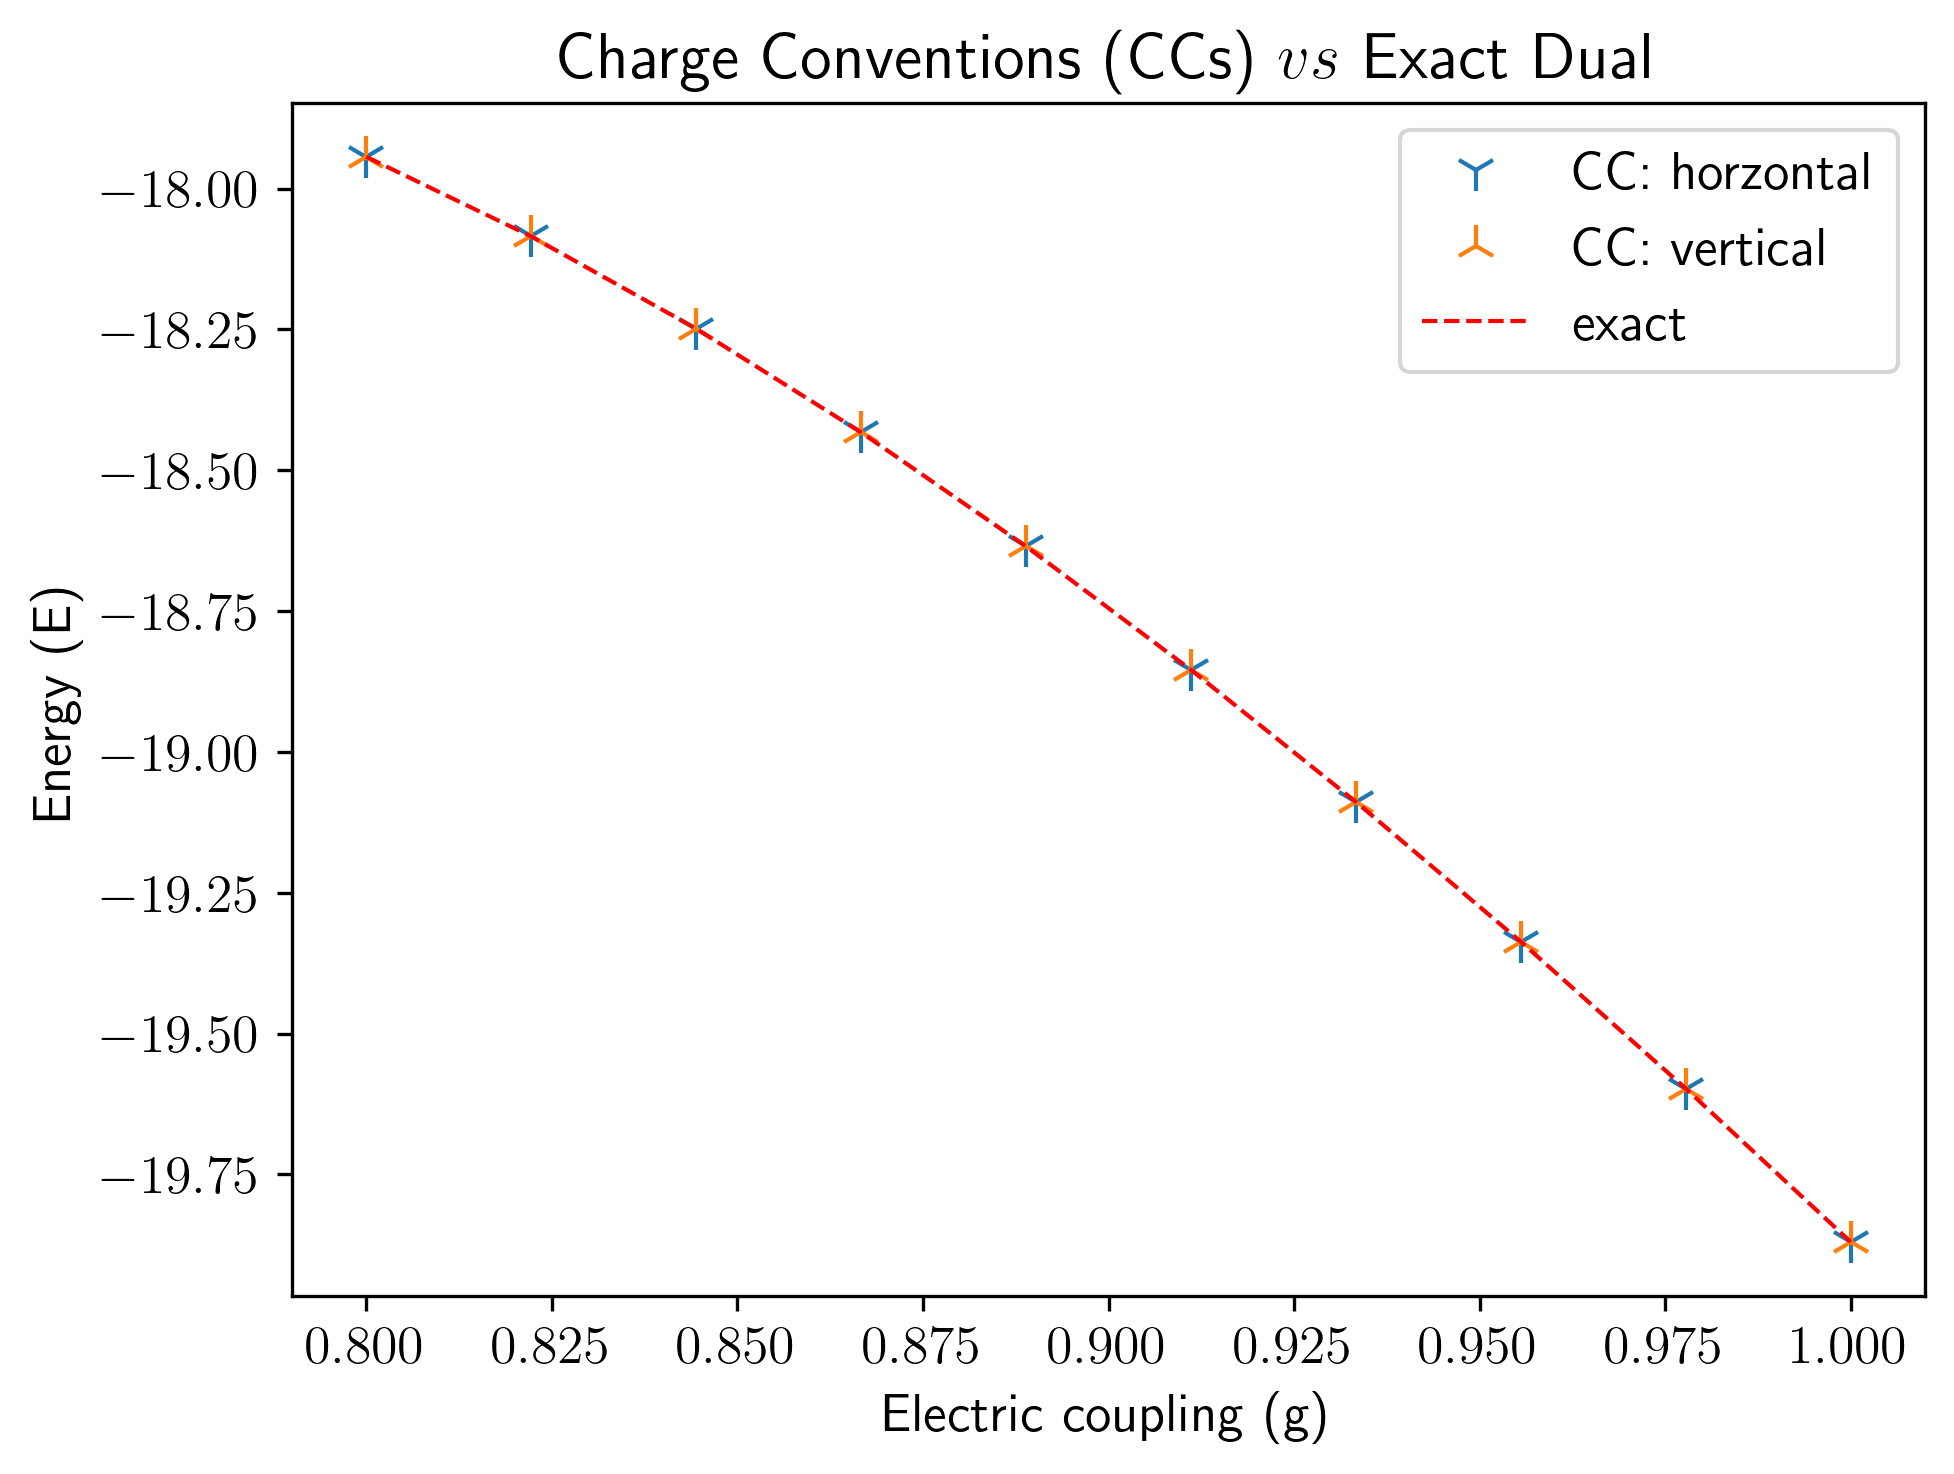

In [8]:
import matplotlib.pyplot as plt
# new = np.load("/Users/fradm98/Library/CloudStorage/GoogleDrive-fra.di.marcantonio@gmail.com/My Drive/projects/1_Z2/results/energy_data/energy_new_Z2_dual_direct_lattice_4x4_2_particle(s)_sector_bc_obc_[0, 4]-[2, 2]_h_0.8-1.0_delta_10_chi_8.npy")
# old = np.load("/Users/fradm98/Library/CloudStorage/GoogleDrive-fra.di.marcantonio@gmail.com/My Drive/projects/1_Z2/results/energy_data/energy_old_Z2_dual_direct_lattice_4x4_2_particle(s)_sector_bc_obc_[0, 4]-[2, 2]_h_0.8-1.0_delta_10_chi_8.npy")
exact = np.loadtxt('/Users/fradm98/Library/CloudStorage/GoogleDrive-fra.di.marcantonio@gmail.com/My Drive/projects/1_Z2/results/exact/energy_data/energy_Z2_dual_direct_lattice_3x3_2_particle(s)_sector_[0, 3]-[1, 1]_h_0.8-1.0_delta_10')

new = np.load('/Users/fradm98/Library/CloudStorage/GoogleDrive-fra.di.marcantonio@gmail.com/My Drive/projects/1_Z2/results/energy_data/energy_new_Z2_dual_direct_lattice_3x3_2_particle(s)_sector_bc_obc_[0, 3]-[1, 1]_h_0.8-1.0_delta_10_chi_8.npy')
old = np.load('/Users/fradm98/Library/CloudStorage/GoogleDrive-fra.di.marcantonio@gmail.com/My Drive/projects/1_Z2/results/energy_data/energy_old_Z2_dual_direct_lattice_3x3_2_particle(s)_sector_bc_obc_[0, 3]-[1, 1]_h_0.8-1.0_delta_10_chi_8.npy')
plt.plot(np.linspace(0.8,1.0,10), new, marker='1', linestyle='', markersize=10, label="CC: horzontal")
plt.plot(np.linspace(0.8,1.0,10), old, marker='2', linestyle='', markersize=10, label="CC: vertical")
plt.plot(np.linspace(0.8,1.0,10), exact, color='red',linestyle='--', linewidth=1, label="exact")
plt.title("Charge Conventions (CCs) $vs$ Exact Dual")
plt.xlabel("Electric coupling (g)")
plt.ylabel("Energy (E)")
plt.legend()

In [19]:
from qs_mps.mps_class import MPS
interval = np.linspace(0.8,1.0,10)
cx = [0,3]
cy = [1,1]
en_v_mps_v = []
en_h_mps_v = []
for h in interval:
    lattice_mps = MPS(L=3, d=8, model="Z2_dual", chi=8, h=h, bc="obc")
    lattice_mps.Z2.add_charges(cx,cy)
    lattice_mps._random_state(seed=3, type_shape="rectangular")
    lattice_mps.canonical_form(trunc_chi=True, trunc_tol=False)
    lattice_mps.w = lattice_mps.Z2.mpo_Z2_ladder_generalized_obc_cc_v().copy()
    energy_cc_v_mps_v, entropy, schmidt_vals, t_dmrg = lattice_mps.DMRG(trunc_chi=True, trunc_tol=False)
    en_v_mps_v.append(energy_cc_v_mps_v[-1])
    lattice_mps.w = lattice_mps.Z2.mpo_Z2_ladder_generalized_obc_cc_h().copy()
    en_h_mps_v.append(lattice_mps.mpo_first_moment().real)

en_v_mps_h = []
en_h_mps_h = []
for h in interval:
    lattice_mps = MPS(L=3, d=8, model="Z2_dual", chi=8, h=h, bc="obc")
    lattice_mps.Z2.add_charges(cx,cy)
    lattice_mps._random_state(seed=3, type_shape="rectangular")
    lattice_mps.canonical_form(trunc_chi=True, trunc_tol=False)
    lattice_mps.w = lattice_mps.Z2.mpo_Z2_ladder_generalized_obc_cc_h().copy()
    energy_cc_h_mps_h, entropy, schmidt_vals, t_dmrg = lattice_mps.DMRG(trunc_chi=True, trunc_tol=False)
    en_h_mps_h.append(energy_cc_h_mps_h[-1])
    lattice_mps.w = lattice_mps.Z2.mpo_Z2_ladder_generalized_obc_cc_v().copy()
    en_v_mps_h.append(lattice_mps.mpo_first_moment().real)

Sweep n: 0

Sweep n: 1

##############################
The energy between the two last updated states converged
to an order of 1e-10 after:
1 sweeps at site 2
total iterations 5
total time: 0.1597327630734071
##############################
Sweep n: 0

Sweep n: 1

##############################
The energy between the two last updated states converged
to an order of 1e-10 after:
1 sweeps at site 2
total iterations 5
total time: 0.16148524603340775
##############################
Sweep n: 0

Sweep n: 1

##############################
The energy between the two last updated states converged
to an order of 1e-10 after:
1 sweeps at site 2
total iterations 5
total time: 0.1579588500317186
##############################
Sweep n: 0

Sweep n: 1

##############################
The energy between the two last updated states converged
to an order of 1e-10 after:
1 sweeps at site 2
total iterations 5
total time: 0.15999962005298585
##############################
Sweep n: 0

Sweep n: 1

##############

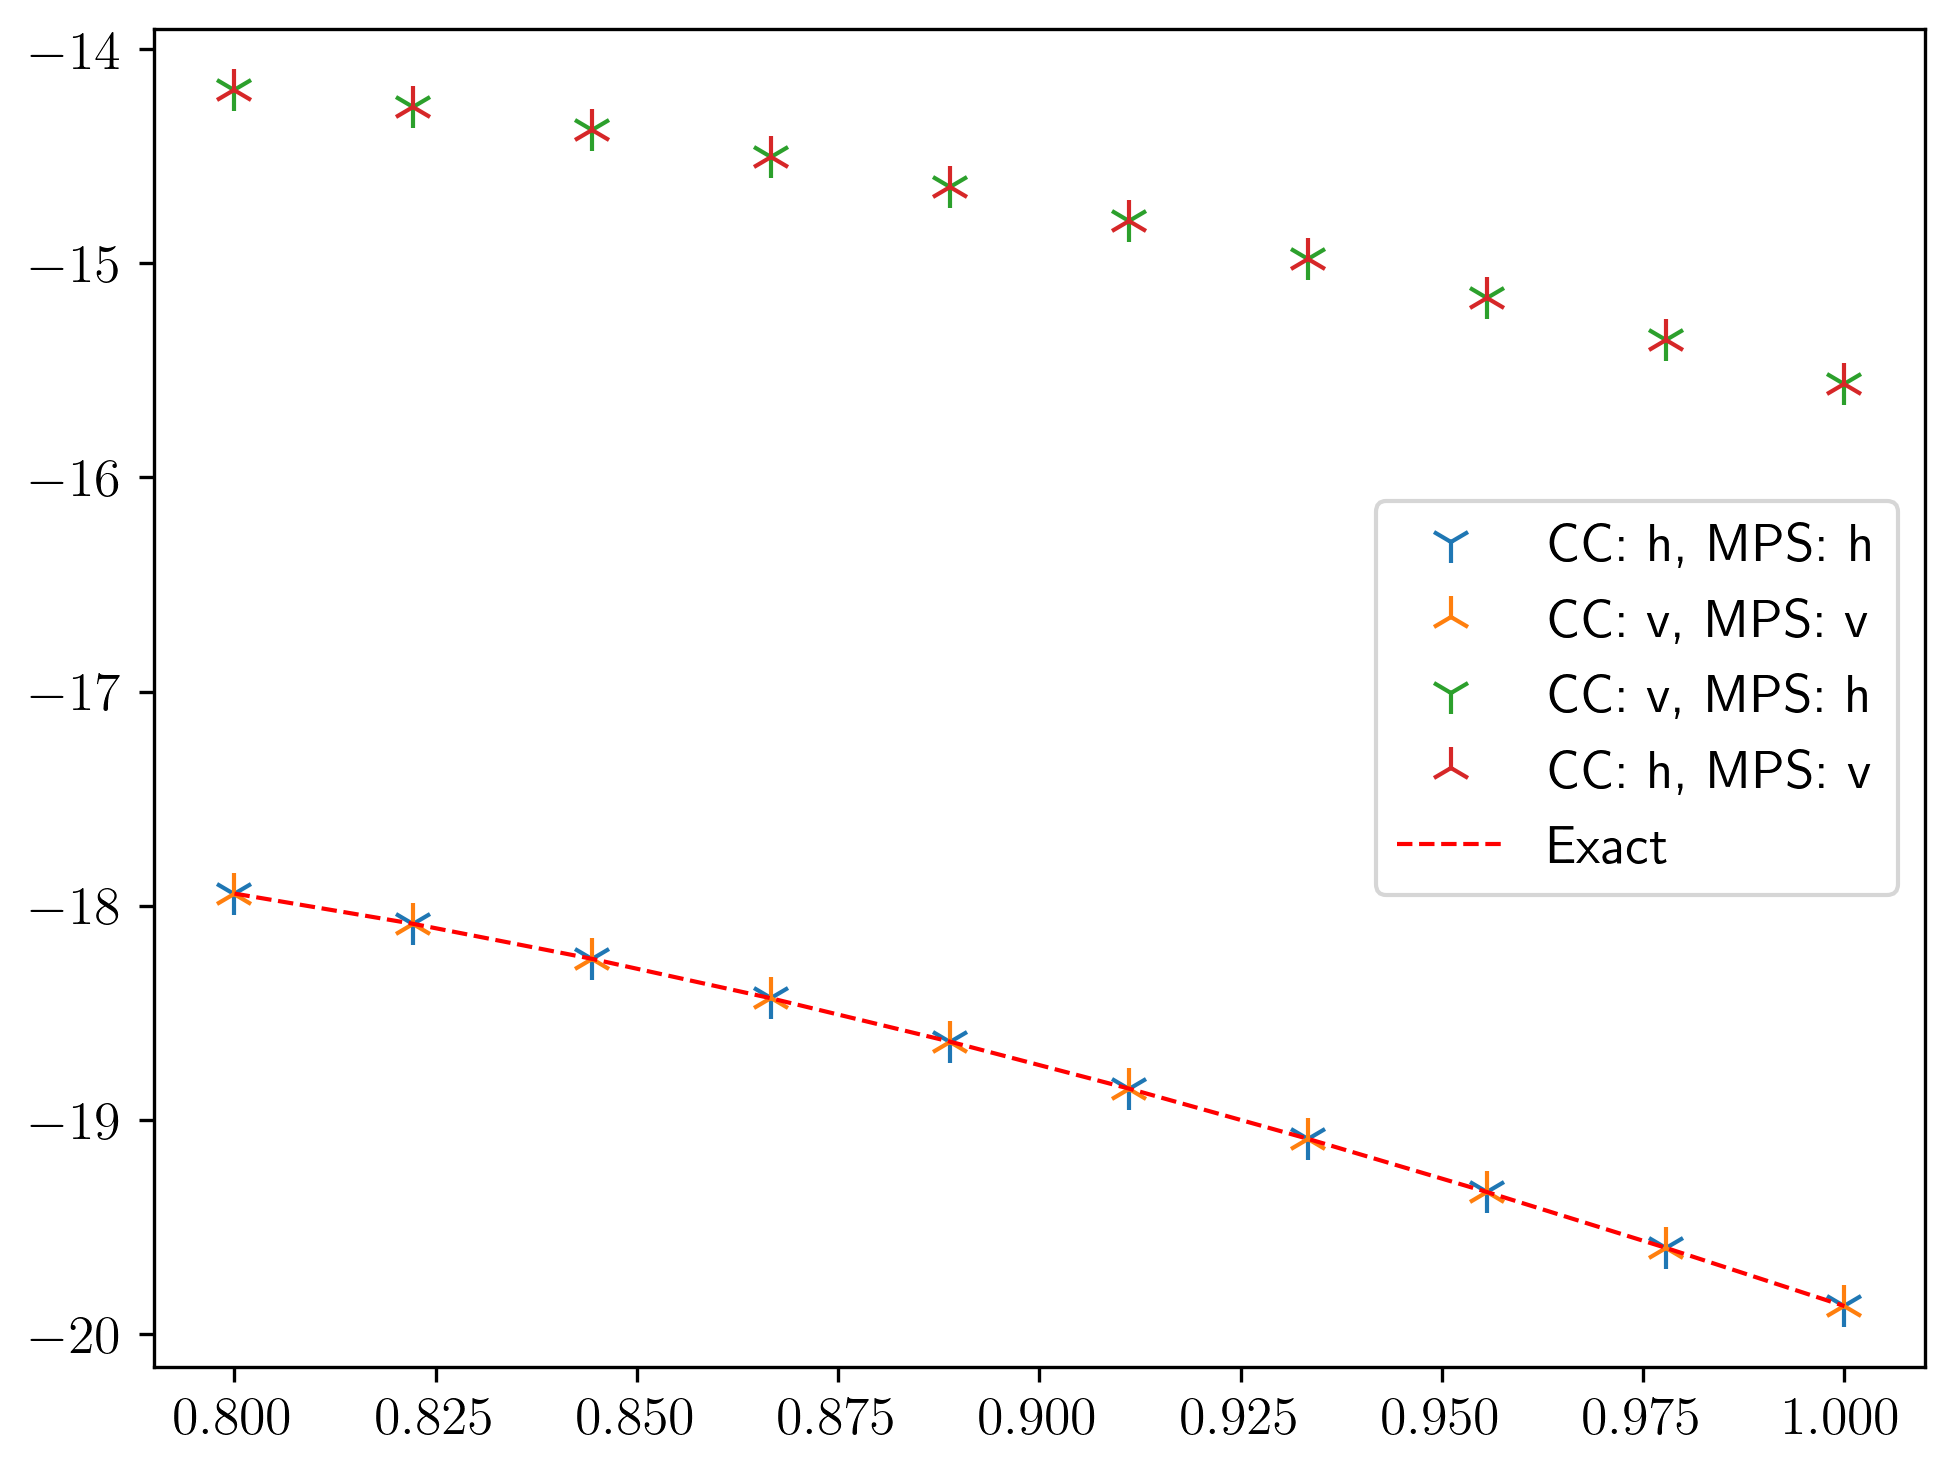

In [21]:
plt.plot(interval, en_h_mps_h, marker='1', markersize=10, linestyle='', label='CC: h, MPS: h')
plt.plot(interval, en_v_mps_v, marker='2', markersize=10, linestyle='', label='CC: v, MPS: v')
plt.plot(interval, en_v_mps_h, marker='1', markersize=10, linestyle='', label='CC: v, MPS: h')
plt.plot(interval, en_h_mps_v, marker='2', markersize=10, linestyle='', label='CC: h, MPS: v')
plt.plot(interval, exact, linewidth=1, linestyle='--', color='red', label='Exact')
plt.legend()